# Robust and Stochastic Optimal Control

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import MX, SX, DM, Function, Opti
import casadi as cas
from platform import python_version

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.5
Python: 3.12.4


In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
# Physical constants

T = 1.0  # control horizon [s]
N = 40  # Number of control intervals

dt = T / N  # length of 1 control interval [s]

tgrid = np.linspace(0, T, N+1)
tgrid.shape

(41,)

## Continuous system $\dot{x}=f(x,u)$

Van der Pol oscillator

$$
\frac{d\left[\begin{array}{l}
x_1 \\
x_2
\end{array}\right]}{d t}=\left[\begin{array}{c}
x_2 \\
-0.1\left(1-x_1^2\right) x_2-x_1+u
\end{array}\right]
$$

In [4]:
nx = 2

# Expression for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u')
x = cas.vertcat(x1, x2)
rhs = cas.vertcat(x2, -0.1 * (1 - x1**2) * x2 - x1 + u)

# Upper bound on first state variable
x1_bound = lambda t: 2 + 0.1 * cas.cos(10 * t)

## Discrete system $x_{k+1} = F(x_k,u_k)$

In [5]:
intg = cas.integrator('intg', 'cvodes', {'x': x, 'p': u, 'ode': rhs}, 0, dt)

## 1. Stochastic Optimal Control

$$
\begin{array}{cl}
\underset{x(\cdot), u(\cdot)}{\operatorname{minimize}} & \int_0^T\left\|x_1(t)-3\right\|_2^2 d t \\
\text { subject to } & \dot{x}(t)=f(x(t), u(t)) \quad \forall t \in[0, T] \\
& -40 \leq u(t) \leq 40 \quad \forall t \in[0, T] \\
& -0.25 \leq x_1(t) \leq b(t) \quad \forall t \in[0, T] \\
& x(0)=\hat{x}
\end{array}
$$

### Template code – Optimal control problem, multiple shooting

In [6]:
x0 = cas.vertcat(0.5, 0)

opti = Opti()

# Decision variable for states
x = opti.variable(nx)

# Initial constraints
opti.subject_to(x == x0)

U = []
X = [x]

# Gap-closing shooting constraints
for k in range(N):
  u = opti.variable()
  U.append(u)

  x_next = opti.variable(nx)
  res = intg(x0=x, p=u)
  opti.subject_to(x_next == res["xf"])

  opti.subject_to(opti.bounded(-40, u, 40))
  opti.subject_to(opti.bounded(-0.25, x[0], x1_bound(tgrid[k])))
  
  x = x_next
  X.append(x)

opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound(tgrid[N])))
U = cas.hcat(U)
X = cas.hcat(X)

opti.minimize(cas.sumsqr(X[0, :] - 3))

opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      322
Number of nonzeros in inequality constraint Jacobian.:       81
Number of nonzeros in Lagrangian Hessian.............:      241

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality c

In [7]:
sol1_x = np.array(sol.value(X))

### Post-processing: plotting

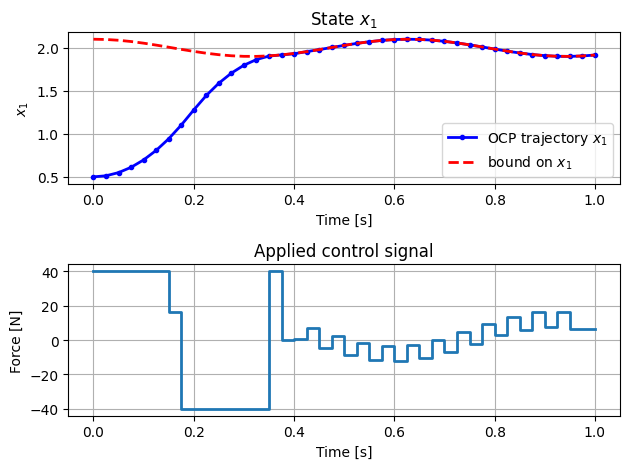

In [8]:
def make_ioplot(tgrid, xsol, usol):
    fig, axes = plt.subplots(2, 1)
    
    ax = axes[0]
    ax.plot(tgrid, xsol[0, :].T, 'b.-', linewidth=2, label='OCP trajectory $x_1$')
    ax.plot(tgrid, x1_bound(tgrid), 'r--', linewidth=2, label='bound on $x_1$')
    ax.set_title('State $x_1$')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('$x_1$')
    ax.grid()
    ax.legend()
    
    ax = axes[1]
    ax.step(tgrid, cas.vertcat(usol, usol[-1]), linewidth=2)
    ax.set_title('Applied control signal')
    ax.set_ylabel('Force [N]')
    ax.set_xlabel('Time [s]')
    ax.grid()

    return fig, axes

usol = sol.value(U)
xsol = sol.value(X)
make_ioplot(tgrid, xsol, usol)
plt.tight_layout()
filename = "robust_sol_1_1_0_ioplot.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.1. Augment the multiple-shooting implementation with the covariance dynamics

$$
\begin{array}{cl}
\underset{x(\cdot), u(\cdot)}{\operatorname{minimize}} & \int_0^T\left\|x_1(t)-3\right\|_2^2 d t \\
\text { subject to } & \dot{x}(t)=f(x(t), u(t)) \quad \forall t \in[0, T] \\
& x(0)=\hat{x} \\
& \dot{\Sigma}_{x(t)}=\frac{\partial f}{\partial x}(x(t), u(t)) \Sigma_{x(t)}+\Sigma_{x(t)} \frac{\partial f^T}{\partial x}(x(t), u(t))+Q(t) \quad \forall t \in[0, T] \\
& \Sigma_{x(0)}=\Sigma_{\hat{x}} \\
& -40 \leq u(t) \leq 40 \quad \forall t \in[0, T] \\
& -0.25 \leq x_1(t) \leq b(t) \quad \forall t \in[0, T]
\end{array}
$$

In [9]:
# Expression for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u')
dxdt_rhs = cas.vertcat(x2, -0.1 * (1 - x1**2) * x2 - x1 + u)
dxdt_rhs

MX(vertcat(x2, ((((-0.1*(1-sq(x1)))*x2)-x1)+u)))

In [10]:
x = cas.vertcat(x1, x2)
dfdx = cas.jacobian(dxdt_rhs, x)
dfdu = cas.jacobian(dxdt_rhs, u)
assert dfdx.shape == (2, 2)
assert dfdu.shape == (2, 1)

In [11]:
# Expression for propagating the covariance matrix
P = MX.sym('sigma_x', 2, 2)
dPdt_rhs = dfdx @ P + P @ dfdx.T
assert dPdt_rhs.shape == (2, 2)

In [12]:
rhs = cas.vertcat(dxdt_rhs, cas.vec(dPdt_rhs))
x_aug = cas.vertcat(x, cas.vec(P))
assert rhs.shape == (6, 1)
assert x_aug.shape == (6, 1)

In [13]:
x1_bound = lambda t: 2 + 0.1 * cas.cos(10 * t)

In [14]:
intg = cas.integrator('intg', 'cvodes', {'x': x_aug, 'p': u, 'ode': rhs}, 0, dt)
intg

Function(intg:(x0[6],z0[0],p,u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[6],zf[0],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) CvodesInterface)

In [15]:
# Initial condition is defined by a Gaussian distribution
x0 = cas.vertcat(0.5, 0)

### Optimal control problem, multiple shooting

In [16]:
opti = Opti()

# Decision variable for states
x = opti.variable(nx)
P = opti.variable(nx, nx)

# Initial constraints
opti.subject_to(x == x0)
opti.subject_to(P == cas.diag([0.01**2, 0.1**2]))

U = []
X = [x]
Ps = [P]
# Gap-closing shooting constraints
for k in range(N):
    u = opti.variable()
    U.append(u)

    x_next = opti.variable(nx)
    P_next = opti.variable(nx, nx)
    res = intg(x0=cas.vertcat(x, cas.vec(P)), p=u)

    xf = res["xf"][:nx]
    Pf = cas.reshape(res["xf"][nx:], nx, nx)
    opti.subject_to(x_next == xf)
    opti.subject_to(cas.vec(P_next) == cas.vec(Pf))

    opti.subject_to(opti.bounded(-40, u, 40))
    opti.subject_to(opti.bounded(-0.25, x[0], x1_bound(tgrid[k])))

    x = x_next
    P = P_next

    Ps.append(P)
    X.append(x)

opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound(tgrid[N])))
U = cas.hcat(U)
X = cas.hcat(X)

opti.minimize(cas.sumsqr(X[0, :] - 3))

opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1606
Number of nonzeros in inequality constraint Jacobian.:       81
Number of nonzeros in Lagrangian Hessian.............:      721

Total number of variables............................:      286
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:       81
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       81
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.6900000e+02 5.00e-01 1.17e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### Post-processing: plotting

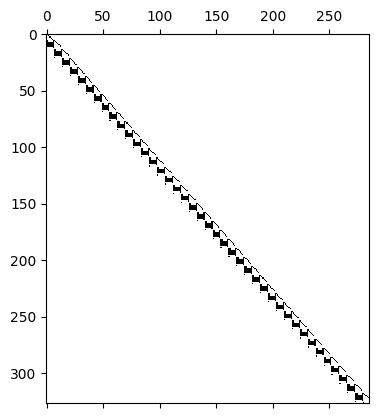

In [17]:
plt.figure()
plt.spy(sol.value(cas.jacobian(opti.g, opti.x)))

In [18]:
print(sol.value(Ps[-1]))
assert_array_almost_equal(
    np.array(sol.value(Ps[-1])),
    [[0.0094851, 0.0073140], 
     [0.0073140, 0.0058025]],
    decimal=7
)

[[0.0094851  0.00731403]
 [0.00731403 0.00580253]]


In [19]:
print(np.max(np.abs(sol.value(X) - sol1_x)))
assert_array_almost_equal(sol.value(X), sol1_x, decimal=3)

0.000831784192147883


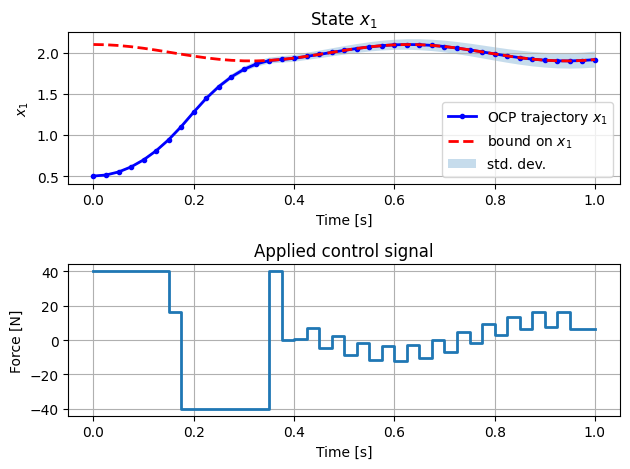

In [20]:
def make_ioplot_with_error_bars(tgrid, xsol, usol, Psol, alpha=0.25):
    fig, axes = make_ioplot(tgrid, xsol, usol)
    ax = axes[0]
    y_err = np.sqrt(Psol[0, :])
    ax.fill_between(tgrid, xsol[0, :] - y_err, xsol[0, :] + y_err, alpha=alpha, label='std. dev.')
    ax.legend()
    return fig, axes

usol = sol.value(U)
xsol = sol.value(X)
Psol = np.array([sol.value(cas.diag(p)) for p in Ps]).T
make_ioplot_with_error_bars(tgrid, xsol, usol, Psol)
plt.tight_layout()
filename = "robust_sol_1_1_1_ioplot.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.2 Make the path constraint on $x_1(t)$ stochastically robust,

In [21]:
opti = Opti()

# Decision variable for states
x = opti.variable(nx)
P = opti.variable(nx, nx)
opti.set_initial(P, np.eye(2))

# Initial constraints
opti.subject_to(x == x0)
opti.subject_to(P == cas.diag([0.01**2, 0.1**2]))

U = []
X = [x]
Ps = [P]
# Gap-closing shooting constraints
for k in range(N):
    u = opti.variable()
    U.append(u)

    x_next = opti.variable(nx)
    P_next = opti.variable(nx, nx)
    opti.set_initial(P_next, np.eye(2))
    res = intg(x0=cas.vertcat(x, cas.vec(P)), p=u)

    xf = res["xf"][:nx]
    Pf = cas.reshape(res["xf"][nx:], nx, nx)
    opti.subject_to(x_next == xf)
    opti.subject_to(cas.vec(P_next) == cas.vec(Pf))

    opti.subject_to(opti.bounded(-40, u, 40))
    var = cas.horzcat(1, 0) @ P @ cas.vertcat(1, 0)
    sigma = cas.sqrt(var)
    opti.subject_to(opti.bounded(-0.25, x[0], x1_bound(tgrid[k]) - sigma))

    x = x_next
    P = P_next

    Ps.append(P)
    X.append(x)

var = cas.horzcat(1,0) @ P @ cas.vertcat(1,0)
sigma = cas.sqrt(var)
opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound(tgrid[N]) - sigma))
U = cas.hcat(U)
X = cas.hcat(X)

opti.minimize(cas.sumsqr(X[0, :] - 3))

opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1606
Number of nonzeros in inequality constraint Jacobian.:      286
Number of nonzeros in Lagrangian Hessian.............:     1131

Total number of variables............................:      286
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      122
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       40
        inequality constraints with only upper bounds:       82

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.6900000e+02 1.00e+00 1.14e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

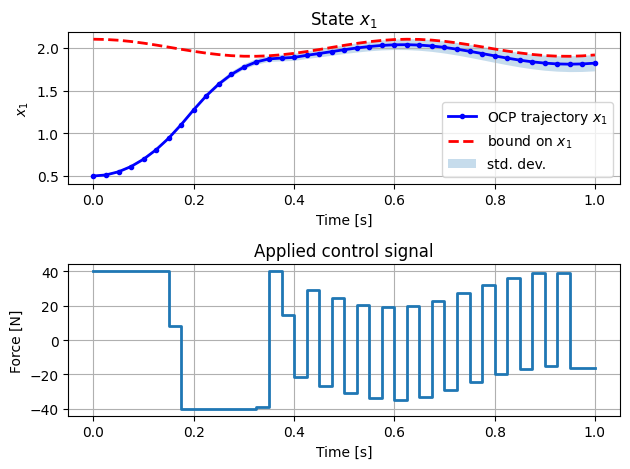

In [22]:
usol = sol.value(U)
xsol = sol.value(X)
Psol = np.array([sol.value(cas.diag(p)) for p in Ps]).T
make_ioplot_with_error_bars(tgrid, xsol, usol, Psol)
plt.tight_layout()
filename = "robust_sol_1_1_2_ioplot.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [23]:
obj_final = sol.stats()['iterations']['obj'][-1]
print(obj_final)
assert np.isclose(obj_final, 8.5443900e+01, rtol=0, atol=1e-6)

85.44389964919894


## 2. Robust Optimal Control

Modified system dynamics

$$
\frac{d\left[\begin{array}{l}
x_1 \\
x_2
\end{array}\right]}{d t}=\left[\begin{array}{c}
x_2 \\
-0.1\left(1-x_1^2+\delta\right) x_2-x_1+u+\delta
\end{array}\right]
$$

where $\delta$ is an adversial disturbance that, in each control interval can be realized as either -1 or +1.

### Continuous system $\dot{x}=f(x,u,\delta)$

In [24]:
nx = 2

# Expression for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u')
x = cas.vertcat(x1, x2)
delta = MX.sym('delta')
rhs = cas.vertcat(x2, -0.1 * (1 - x1**2 + delta) * x2 - x1 + u)

# Upper bound on first state variable
x1_bound = lambda t: 2 + 0.1 * cas.cos(10 * t)

### Discrete system $x_{k+1} = F(x_k,u_k,\delta_k)$

In [25]:
intg = cas.integrator('intg', 'cvodes', {'x': x, 'p': cas.vertcat(u, delta), 'ode': rhs}, 0, dt)

### Generate scenarios

In [26]:
from itertools import product

N = 6
delta_num = 1
delta_values = [-delta_num, delta_num]
scenarios = list(product(*[delta_values]*N))
scenarios[:10]

[(-1, -1, -1, -1, -1, -1),
 (-1, -1, -1, -1, -1, 1),
 (-1, -1, -1, -1, 1, -1),
 (-1, -1, -1, -1, 1, 1),
 (-1, -1, -1, 1, -1, -1),
 (-1, -1, -1, 1, -1, 1),
 (-1, -1, -1, 1, 1, -1),
 (-1, -1, -1, 1, 1, 1),
 (-1, -1, 1, -1, -1, -1),
 (-1, -1, 1, -1, -1, 1)]

### Optimal control problem, multiple shooting

In [27]:
x0 = cas.vertcat(0.5, 0)

opti = Opti()

# Decision variable for states
x = opti.variable(nx)

# Initial constraints
opti.subject_to(x == x0)

U = []
X = [x]

# Instead of true non-anticipativity constraints,
# we just have one common control sequence for all scenarios.
U = opti.variable(1, N)
opti.subject_to(opti.bounded(-40, U.T, 40))

# Sample the state bounds
x1_bound_sampled = x1_bound(tgrid)

In [28]:
def build_scenario_tree(opti, intg, delta_values, depth, x, x1_bound, U):
    """Builds a scenario tree recursively

    Arguments to be passed as is: opti, intg, delta_values

    depth: remaining horizon (decrements while recursing)
    x: previous state  (remains same size)
    x1_bound: remaining list of bounds for state (shrinks while recursing)
    U: remaining control variables (shrinks while recursing)

    Returns a tuple with the initial state and a dictionary containing the
    branches of the tree down to the specified recursion depth.
    """
    if depth == 0:
        tree = None
    else:
        tree = {}
        for delta in delta_values:
            x_next = opti.variable(*x.shape)
            res = intg(x0=x, p=cas.vertcat(U[0], delta))
            opti.subject_to(x_next==res["xf"])
            opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound[0]))
            tree[delta] = build_scenario_tree(opti, intg, delta_values, depth-1, x_next, x1_bound[1:], U[1:])

    return (x, tree)


In [29]:
tree = build_scenario_tree(opti, intg, delta_values, N, x, x1_bound_sampled[1:], U)

tree

(MX(opti3_x_1),
 {-1: (MX(opti3_x_3),
   {-1: (MX(opti3_x_4),
     {-1: (MX(opti3_x_5),
       {-1: (MX(opti3_x_6),
         {-1: (MX(opti3_x_7),
           {-1: (MX(opti3_x_8), None), 1: (MX(opti3_x_9), None)}),
          1: (MX(opti3_x_10),
           {-1: (MX(opti3_x_11), None), 1: (MX(opti3_x_12), None)})}),
        1: (MX(opti3_x_13),
         {-1: (MX(opti3_x_14),
           {-1: (MX(opti3_x_15), None), 1: (MX(opti3_x_16), None)}),
          1: (MX(opti3_x_17),
           {-1: (MX(opti3_x_18), None), 1: (MX(opti3_x_19), None)})})}),
      1: (MX(opti3_x_20),
       {-1: (MX(opti3_x_21),
         {-1: (MX(opti3_x_22),
           {-1: (MX(opti3_x_23), None), 1: (MX(opti3_x_24), None)}),
          1: (MX(opti3_x_25),
           {-1: (MX(opti3_x_26), None), 1: (MX(opti3_x_27), None)})}),
        1: (MX(opti3_x_28),
         {-1: (MX(opti3_x_29),
           {-1: (MX(opti3_x_30), None), 1: (MX(opti3_x_31), None)}),
          1: (MX(opti3_x_32),
           {-1: (MX(opti3_x_33), None), 1

In [30]:
def get_states_from_tree(tree, seq):
    states = [tree[0]]
    if len(seq) > 0:
        states += get_states_from_tree(tree[1][seq[0]], seq[1:])
    return states

get_states_from_tree(tree, scenarios[0])

[MX(opti3_x_1),
 MX(opti3_x_3),
 MX(opti3_x_4),
 MX(opti3_x_5),
 MX(opti3_x_6),
 MX(opti3_x_7),
 MX(opti3_x_8)]

In [31]:
# Gap-closing shooting constraints
U = []
for k in range(N):
    u = opti.variable()
    U.append(u)

    x_next = opti.variable(nx)
    res = intg(x0=x, p=u)
    opti.subject_to(x_next == res["xf"])

    opti.subject_to(opti.bounded(-40, u, 40))
    opti.subject_to(opti.bounded(-0.25, x[0], x1_bound(tgrid[k])))

    x = x_next
    X.append(x)

opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound(tgrid[N])))
U = cas.hcat(U)
X = cas.hcat(X)

opti.minimize(cas.sumsqr(X[0, :] - 3))

opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1058
Number of nonzeros in inequality constraint Jacobian.:      145
Number of nonzeros in Lagrangian Hessian.............:      355

Total number of variables............................:      278
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      266
Total number of inequality constraints...............:      145
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      145
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.3000000e+01 5.00e-01 3.34e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [32]:
nx = 2

# Expression for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u')
x = cas.vertcat(x1, x2)
rhs = cas.vertcat(x2, -0.1 * (1 - x1**2) * x2 - x1 + u)

# Upper bound on first state variable
x1_bound = lambda t: 2 + 0.1 * cas.cos(10 * t)

In [33]:
def recurse(opti, intg, delta_num, N, x, x1_bound, X_history, U):
    """Builds a scenario tree recursively
    
    Settings to be passed as is: opti, intg, delta_num
    
    N: remaining horizon (shrinks while recursing)
    x: previous state  (remains same size)
    x1_bound: remaining list of bounds for state (shrinks while recursing)
    X_history: a list with the history of the current full branch (grows while recursing)
    U: remaining control variables (shrinks while recursing)
    
    This function returns a list with an entry for each possible series of events (=one full branch)
    Each list entry has a concatenation of all states of that full branch.
    """
    if N == 0:
        return [cas.hcat(X_history)]
    
    obj_total = []
    X = []
    for delta in [-delta_num, delta_num]:
        x_next = opti.variable(2)
        res = intg(x0=x, p=cas.vertcat(U[0], delta))
        opti.subject_to(x_next==res["xf"])
        
        opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound[0]))
        
        X_local = recurse(opti, intg, delta_num, N-1, x_next, x1_bound[1:], X_history + [x_next], U[1:])
        X += X_local
    return X